In [1]:
import pydicom
import matplotlib.pyplot as plt
import os
os.listdir()

['EDA.ipynb', 'DICOMDAT', 'rotation.gif', '.ipynb_checkpoints']

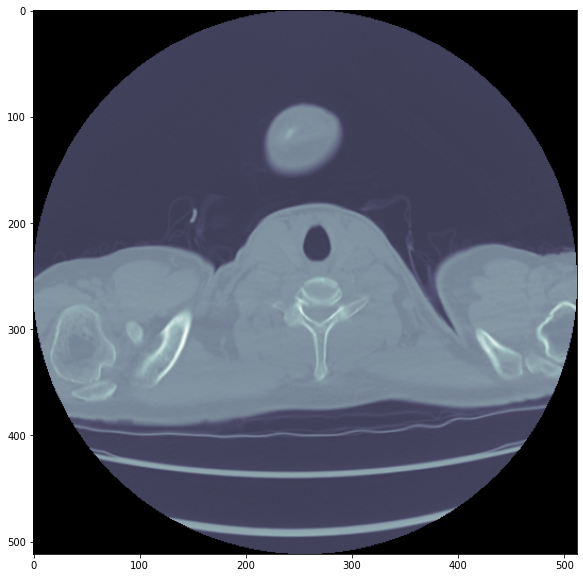

In [2]:
file = './DICOMDAT/SDY00000/SRS00001/IMG00011'
ds = pydicom.dcmread(file)
plt.figure(figsize=(10, 10))
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
plt.show()

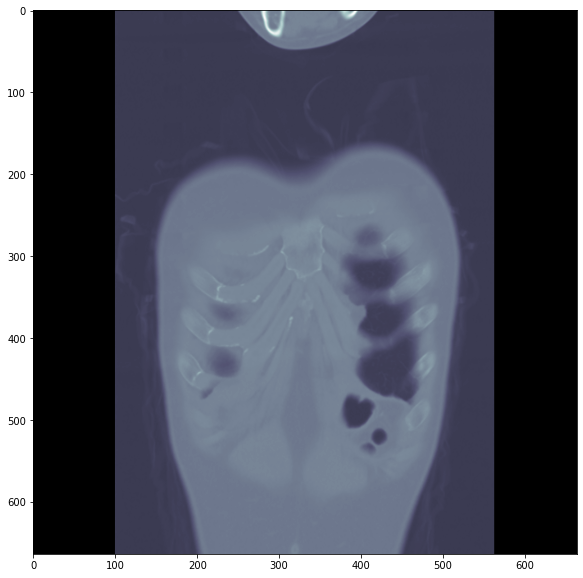

In [3]:
file = './DICOMDAT/SDY00000/SRS00003/IMG00004'
ds = pydicom.dcmread(file)
plt.figure(figsize=(10, 10))
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
plt.show()

In [4]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [5]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness

    return slices

In [6]:
slice = load_scan('./DICOMDAT/SDY00000/SRS00001')
slice

[Dataset.file_meta -------------------------------
 (0002, 0000) File Meta Information Group Length  UL: 198
 (0002, 0001) File Meta Information Version       OB: b'\x00\x01'
 (0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
 (0002, 0003) Media Storage SOP Instance UID      UI: 1.2.392.200036.9116.2.5.1.48.1221222295.1593577264.522790
 (0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
 (0002, 0012) Implementation Class UID            UI: 1.2.528.1.1001.2.20060808.1
 (0002, 0013) Implementation Version Name         SH: 'GEHC_DCM06_1'
 -------------------------------------------------
 (0008, 0000) Group Length                        UL: 660
 (0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
 (0008, 0016) SOP Class UID                       UI: CT Image Storage
 (0008, 0018) SOP Instance UID                    UI: 1.2.392.200036.9116.2.5.1.48.1221222295.1593577264.522790
 (0008, 0020) Study Date        

In [7]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # 转换为int16，int16是ok的，因为所有的数值都应该 <32k
    image = image.astype(np.int16)

    # 设置边界外的元素为0
    image[image == -2000] = 0

    # 转换为HU单位
    for slice_number in range(len(slices)):

        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)

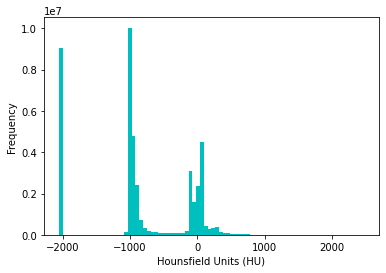

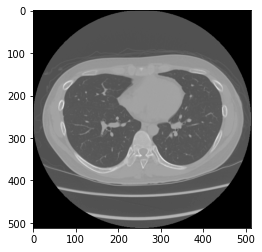

In [8]:
first_patient = slice
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# 显示一个中间位置的切片
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [9]:
def resample(image, scan, new_spacing=[1,1,1]):
    spacing = np.array([float(scan[0].SliceThickness)] + [float(x) for x in scan[0].PixelSpacing], dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    return image, new_spacing

pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (161, 512, 512)
Shape after resampling	 (483, 370, 370)


In [15]:
def plot_3d(image, threshold=400,f=measure.marching_cubes_lewiner,angle=0):

    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces,_,_ = f(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(azim=angle)

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [16]:
'''
from matplotlib.animation import FuncAnimation, PillowWriter,FFMpegFileWriter

def plot_3d_gif(image, threshold=400,f=measure.marching_cubes_lewiner):

    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces,_,_ = f(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    
    def rotate(angle):
        ax.view_init(azim=angle)
        
    #writer = FFMpegFileWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
    writer = PillowWriter
    rot_animation = FuncAnimation(fig,rotate,frames=np.arange(0,360,90),interval=1000)
    rot_animation.save('./rotation.gif',writer=writer,dpi=80)
'''

"\nfrom matplotlib.animation import FuncAnimation, PillowWriter,FFMpegFileWriter\n\ndef plot_3d_gif(image, threshold=400,f=measure.marching_cubes_lewiner):\n\n    # Position the scan upright, \n    # so the head of the patient would be at the top facing the camera\n    p = image.transpose(2,1,0)\n    \n    verts, faces,_,_ = f(p, threshold)\n\n    fig = plt.figure(figsize=(10, 10))\n    ax = fig.add_subplot(111, projection='3d')\n\n    # Fancy indexing: `verts[faces]` to generate a collection of triangles\n    mesh = Poly3DCollection(verts[faces], alpha=0.70)\n    face_color = [0.45, 0.45, 0.75]\n    mesh.set_facecolor(face_color)\n    ax.add_collection3d(mesh)\n\n    ax.set_xlim(0, p.shape[0])\n    ax.set_ylim(0, p.shape[1])\n    ax.set_zlim(0, p.shape[2])\n    \n    def rotate(angle):\n        ax.view_init(azim=angle)\n        \n    #writer = FFMpegFileWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)\n    writer = PillowWriter\n    rot_animation = FuncAnimation(fig,rotate,fra

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  import sys


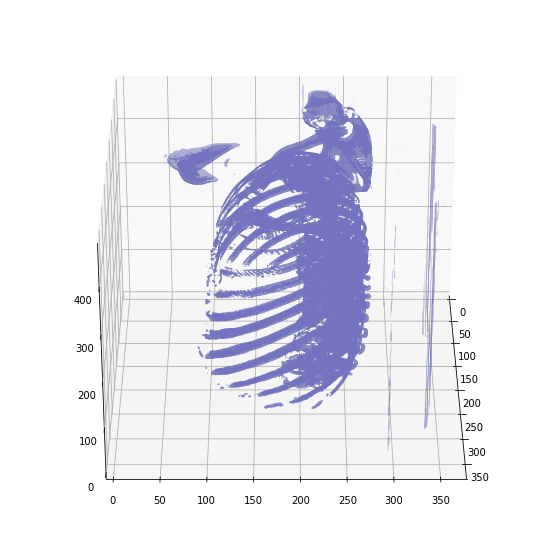

In [17]:
plot_3d(pix_resampled,f=measure.marching_cubes_lewiner,angle=0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  import sys


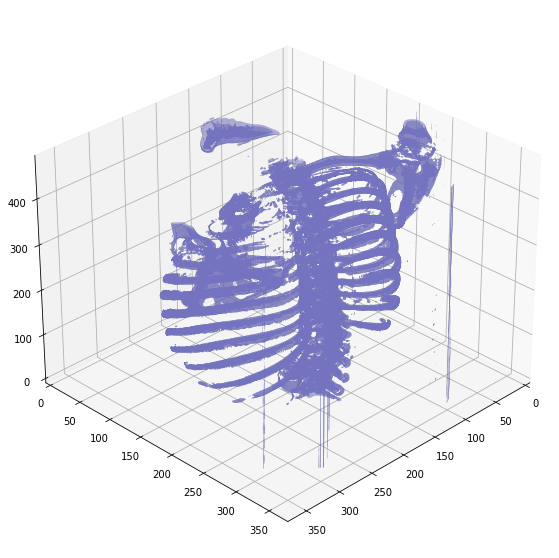

In [21]:
plot_3d(pix_resampled,f=measure.marching_cubes_lewiner,angle=45)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  import sys


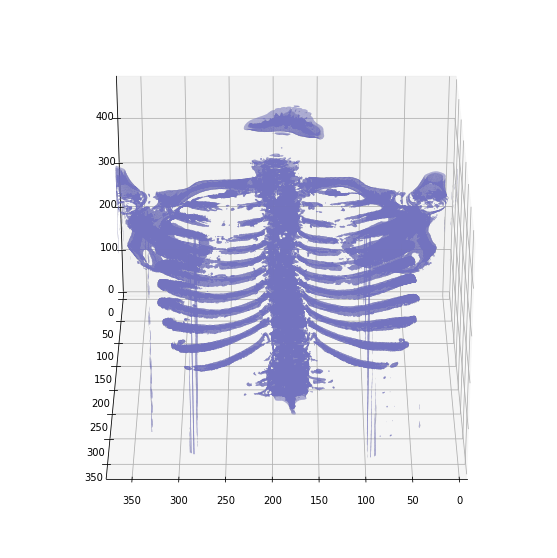

In [18]:
plot_3d(pix_resampled,f=measure.marching_cubes_lewiner,angle=90)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  import sys


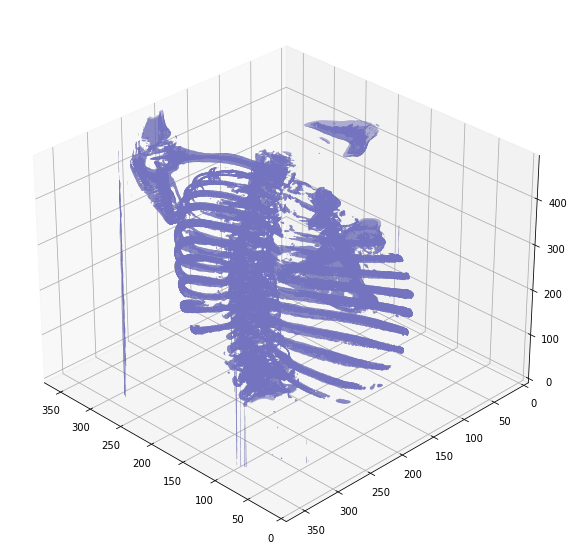

In [22]:
plot_3d(pix_resampled,f=measure.marching_cubes_lewiner,angle=135)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  import sys


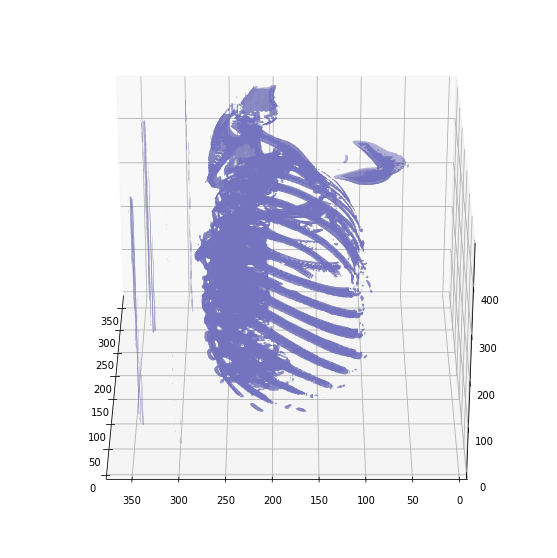

In [19]:
plot_3d(pix_resampled,f=measure.marching_cubes_lewiner,angle=180)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  import sys


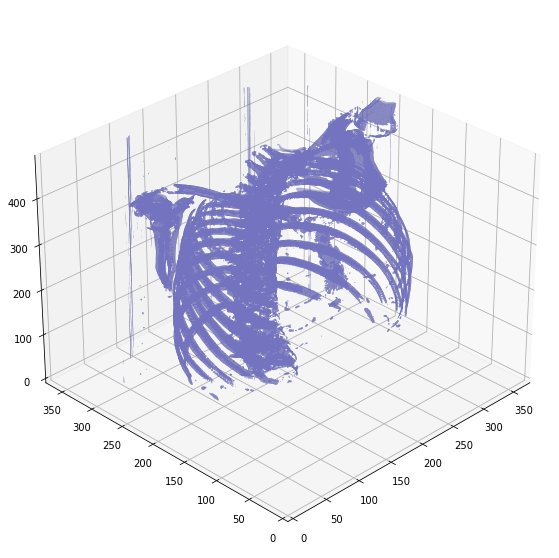

In [23]:
plot_3d(pix_resampled,f=measure.marching_cubes_lewiner,angle=225)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  import sys


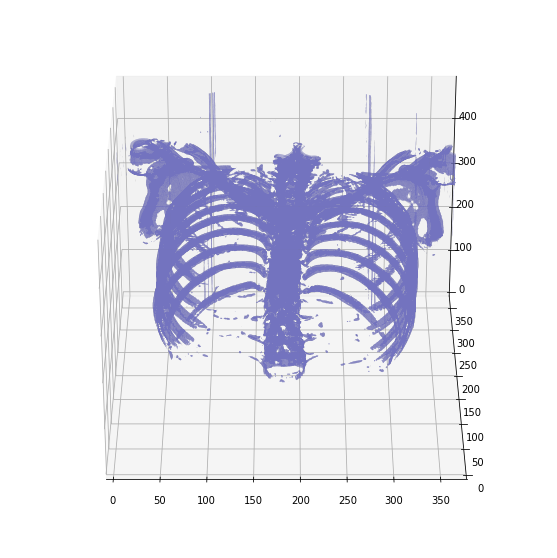

In [20]:
plot_3d(pix_resampled,f=measure.marching_cubes_lewiner,angle=270)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  import sys


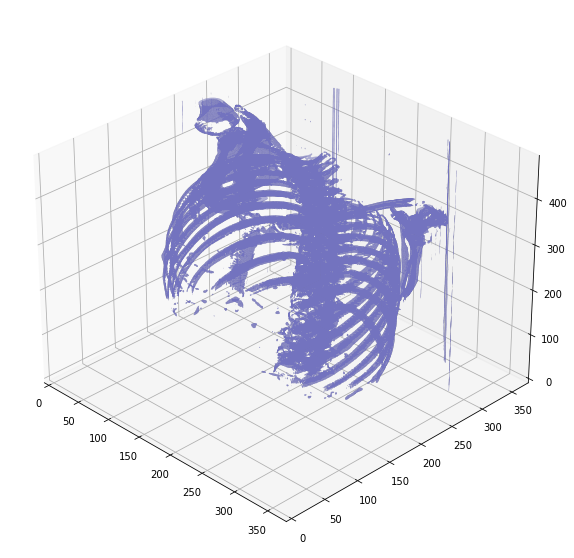

In [24]:
plot_3d(pix_resampled,f=measure.marching_cubes_lewiner,angle=315)